In [40]:
from itertools import product

import numpy as np


from tqdm import tqdm
from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

from graspy.simulations import rdpg
from graspy.embed import AdjacencySpectralEmbed

import sys
sys.path.append("./align/")
from align.seedless_procrustes import SeedlessProcrustes
from align.sign_flips import SignFlips

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def equal(n):
    X = np.random.uniform(.2, .7, size=(n, 1))
    Y = np.random.uniform(.2, .7, size=(n, 1))
    
    return X, Y

def linear(n):
    X = np.random.uniform(.2, .7, size=(n, 1))
    Y = X + 0.1
    
    return X, Y

def nonlinear(n):
    X = np.random.uniform(.2, .7, size=(n, 1))
    b = np.random.beta(.2, .2, size=(n, 1))
    Y = 0.5 * b + 0.2
    
    return X, Y

In [3]:
def hypothesis_test(X1, X2, flip):
    tests = [KSample('Dcorr'), KSample('MGC')]
    
    if flip == 'median':
        X1_flipped = SignFlips('median').fit_transform(X1, X2)
        
    elif flip == 'seedless':
        X1_flipped = SeedlessProcrustes().fit_transform(X1, X2)
        # Q = SeedlessProcrustes().fit_predict(X1, X2)
        # X1_flipped = X1 @ Q
        # X2_flipped = X2
        
    
    pvals = []
    for test in tests:
        res = test.test(X1_flipped, X2, auto=False)
        pvals.append(res[1])
        
    return pvals

In [63]:
def run(data_func, n, flip):
    X, Y = data_func(n)
    A = rdpg(X)
    B = rdpg(Y)
    
    ase = AdjacencySpectralEmbed(n_components=1, diag_aug=True, check_lcc=False)
    Xhat = ase.fit_transform(A)
    Yhat = ase.fit_transform(B)
    
    
    pvals = hypothesis_test(Xhat, Yhat, flip)
    return [*pvals, n, flip, data_func.__name__]

In [64]:
ns = np.linspace(20, 150, 14).astype(int)
datasets = [equal, linear, nonlinear]
flips = ["median", "seedless"]

args = list(product(ns, datasets, flips))

In [65]:
reses = []
for arg in tqdm(args):
    n, dataset, flip = arg
    res = Parallel(-1, verbose=0)(delayed(run)(dataset, n, flip) for _ in range(1000))
    
    reses.extend(res)


100%|██████████| 84/84 [9:33:25<00:00, 409.59s/it]  


In [67]:
cols = ["dcorr", "mgc", "hsic", "n", "flip", "dataset"]

df = pd.DataFrame(reses, columns=cols)

In [68]:
df.head()

,dcorr,mgc,hsic,n,flip,dataset
0,0.049,0.021,0.015,20,median,equal
1,0.693,0.696,0.578,20,median,equal
2,0.296,0.292,0.175,20,median,equal
3,0.711,0.717,0.623,20,median,equal
4,0.028,0.005,0.006,20,median,equal


In [69]:
df.to_csv("./results/simultions_150.csv", index=False)

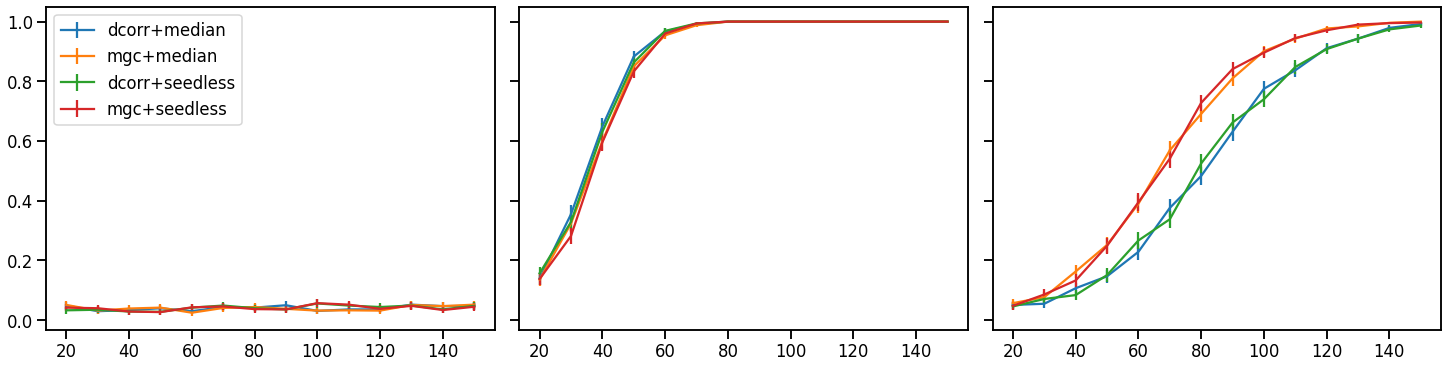

In [79]:
sns.set_context("talk")

fig, axes = plt.subplots(ncols=3, figsize=(20, 5), constrained_layout=True, sharex=True, sharey=True)

for idx, dataset in enumerate(["equal", "linear", "nonlinear"]):
    for flip in flips:
        tmp_df = df[(df.dataset == dataset) & (df.flip == flip)]
        
        for algo in ["dcorr", "mgc"]:
            powers = []
            errs = []
            
            for n in ns:
                power = np.mean(tmp_df[tmp_df.n == n][algo].values <= 0.05)
                err = 1.96 * np.sqrt(power * (1 - power) / 1000) #1000 = num reps
                
                powers.append(power)
                errs.append(err)
                
            axes[idx].errorbar(x = ns, y=powers, yerr=errs, label=f"{algo}+{flip}")
            
axes[0].legend(loc="upper left")


Text(0, 0.5, 'Power')

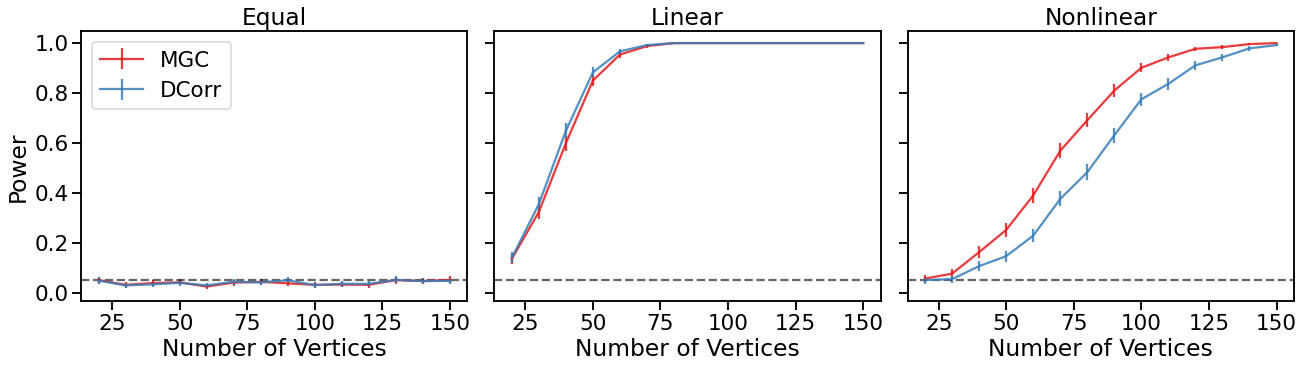

In [98]:
sns.set_context("talk", font_scale=1.3)

titles = ["Equal", "Linear", "Nonlinear"]
algo_titles = ["DCorr", "MGC"][::-1]
colors = ["#e41a1c", "#377eb8"]

fig, axes = plt.subplots(ncols=3, figsize=(18, 5), constrained_layout=True, sharex=True, sharey=True)

for idx, dataset in enumerate(["equal", "linear", "nonlinear"]):
    axes[idx].axhline(0.05, ls="--", c="k", alpha=0.6)

    tmp_df = df[(df.dataset == dataset) & (df.flip == "median")]

    for jdx, algo in enumerate(["dcorr", "mgc"][::-1]):
        powers = []
        errs = []

        for n in ns:
            power = np.mean(tmp_df[tmp_df.n == n][algo].values <= 0.05)
            err = 1.96 * np.sqrt(power * (1 - power) / 1000) #1000 = num reps

            powers.append(power)
            errs.append(err)

        axes[idx].errorbar(x = ns, y=powers, yerr=errs, label=algo_titles[jdx], c=colors[jdx], alpha=0.85)
        
    
    axes[idx].set_xlabel("Number of Vertices")
    axes[idx].set_title(titles[idx],)
            
axes[0].legend(loc="upper left")
axes[0].set_ylabel("Power")

In [99]:
fig.savefig("./figures/simulations.pdf", dpi=300, bbox_inches="tight")
fig.savefig("./figures/simulations.png", dpi=300, bbox_inches="tight")